# 利用pytorch建立MLP, CNN進行MNIST分類模型(介紹Cross Entropy loss的運作)

Pytorch訓練流程<br>

0. 是否使用CUDA <br>
1. 讀資料(dataset和dataloader)<br> 
2. 模型宣告 <br> 
3. 宣告/建立loss function<br>
4. 建立模型的參數最佳化器 <br>
5. 模型開始訓練 <br>

**<font color = blue size=4>  0.是否使用CUDA </font>**<br>

<br>宣告一個device決定CPU或是GPU運算</br>

In [1]:
import torch
use_cuda=1
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


上面是我們自己說要下到cuda裡面，但實際上沒有cuda就慘了

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
print(type(device))
print(torch.cuda.is_available())

cuda
<class 'torch.device'>
True


**<font color = blue size=4>1. 讀資料(dataset和dataloader)</font>**<br><br>
這邊是利用torchvision的模組將MNIST dataset帶入<br>
並且利用torch.utils.data.DataLoader進行dataloader<br>
詳細內容前面課程已經提過了，因此帶過<br>

torch.Size([10, 1, 28, 28])
torch.Size([10, 784])


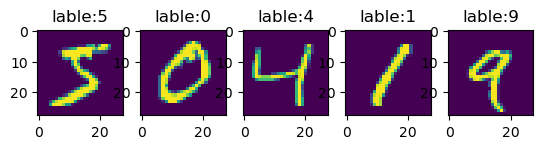

In [3]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=10)
for data in mnistdata_loader:
    image, label = data
    print(image.shape)
    print(image.view(-1,28*28).shape)
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(image[i,0,:,:])
        plt.title('lable:{}'.format(label[i]))
    plt.show()
    break

----------------------
**<font color = blue size=4> 2. 模型宣告</font>**<br>

<br>這邊在宣告你要用什麼神經網路，自己兜得或是開源模型都可以<br>
**1. Single layer perceptron (SLP)** <br>
<br>這邊我們用一個一層Hidden layer </br>
<br>因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=754的一維陣列</br>
<br>所以神經網路的結構為</br>
Input layer (node數為754) → Hidden layer (node數設定為512) → Output layer (node數為10)</br>

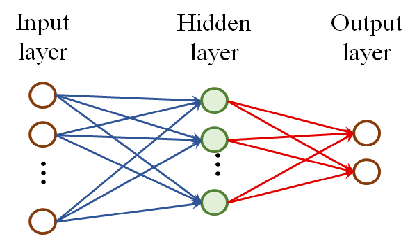

**2. MLP** <br>
<br>這邊我們用一個三層Hidden layer </br>
<br>因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=754的一維陣列</br>
<br>所以神經網路的結構為</br>
Input layer (node數為754) → Hidden layer (node數設定為512) → Hidden layer (node數設定為256) → Hidden layer (node數設定為128) → Output layer (node數為10)</br>

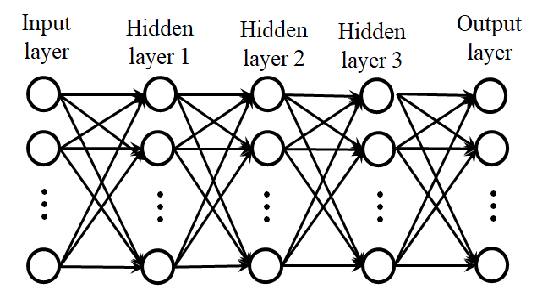





In [4]:
## 1. SLP
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class SLP(nn.Module):
    def __init__(self, n_class):
        super(SLP,self).__init__()
        self.slp = torch.nn.Sequential(
            nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.slp(x)
        return x
    
# define NN architecture
class MLP(nn.Module):
    def __init__(self, n_class):
        super(MLP,self).__init__()
        self.mlp = torch.nn.Sequential(
            nn.Linear(28*28, 96),
            torch.nn.ReLU(),
            nn.Linear(96, 64),
            torch.nn.ReLU(),
            nn.Linear(64, 32),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(32, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.mlp(x)
        return x
    
# initialize the MLP
model_slp = SLP(n_class=10)
print(model_slp)
model_mlp = MLP(n_class=10)
print(model_mlp)

dummy_inpurt = torch.rand(1,1,28,28)
dummy_inpurt = dummy_inpurt.view(-1,28*28)
out=model_slp(dummy_inpurt)
torch.onnx.export(model_slp, dummy_inpurt, './slp.onnx', opset_version=11)
torch.onnx.export(model_mlp, dummy_inpurt, './mlp.onnx', opset_version=11)

SLP(
  (slp): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
MLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)


參數量:
**1. SLP** <br>
Input layer (node數為784) → Hidden layer (node數設定為128) → Output layer (node數為10)</br>
$784 \times 128+128 = 100,480$</br>
$ 128 \times 10+10 = 1,290 $</br>
總參數: 101,770</br>
FP32: 32 bits = 4 Byte</br>
$101,770 \times 4 \div 1024 = 397.5$KB</br>

**2. MLP** <br>
Input layer (node數為784) → Hidden layer (node數設定為96) → Hidden layer (node數設定為64) → Hidden layer (node數設定為32) → Output layer (node數為10)</br>
$784 \times 96+96 = 75,360$</br>
$96 \times 64+64 = 6,208$</br>
$64 \times 32+32 = 2,080$</br>
$32 \times 10+10 = 330$</br>
總參數: 83,978</br>
$83,978  \times 4 \div 1024 = 328.0$KB</br>


----------------------
**<font color = blue size=4> 步驟3.loss function宣告</font>**<br>
<br>宣告loss函數，模型預測的結果和ground truth整合計算差異用來更新模型</br>
<br>這邊提的是和ground truth整合計算差異所以泛屬於supervised learning</br>
<br>reference:https://pytorch.org/docs/stable/nn.html#loss-functions

<br>**這邊我們用到的是cross entropy作為loss function**
<br>torch.nn.CrossEntropyLoss = log_softmax → nll_loss 
<br>log_softmax: torch.nn.functional.log_softmax
<br>nll_loss: torch.nn.functional.nll_loss (negative log likelihood loss)

In [5]:
loss = torch.nn.CrossEntropyLoss()

import numpy as np
x = np.array([[3.0,2.0,1.0],[4.0,5.0,6.0]])
inputdata = torch.tensor(x, requires_grad=True)
target = np.array([0, 2])
target = torch.LongTensor(target)
output1 = loss(inputdata, target)
print('inputdata:{}'.format(inputdata))
print('target:{}'.format(target))
print('loss value by function (torch.nn.CrossEntropyLoss): {}'.format(output1))


from  torch.nn.functional import log_softmax,nll_loss, softmax

ls_x = log_softmax(inputdata,dim=1)
output2 = nll_loss(ls_x, target)
print('loss value by (log_softmax and nll_loss): {}'.format(output2))


inputdata:tensor([[3., 2., 1.],
        [4., 5., 6.]], dtype=torch.float64, requires_grad=True)
target:tensor([0, 2])
loss value by function (torch.nn.CrossEntropyLoss): 0.4076059644443804
loss value by (log_softmax and nll_loss): 0.4076059644443804


所以用程式算Cross entropy分別用這兩種方式計算
<br> 1. torch.nn.CrossEntropyLoss，結果為 0.4076059644443804
<br> 2. log_softmax → nll_loss，結果為 0.4076059644443804
<br>結果是一樣的

<br>**利用手算**:  
<br>$ x = \begin{bmatrix} 3 & 2 & 1 \\ 4 & 5 & 6 \\ \end{bmatrix} $
$, label = \begin{bmatrix} 0 \\ 2 \\ \end{bmatrix} $
<br>Onehot encoder for label:
<br>$ y(label) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix} $

<br> softmax operator:
<br>$ p_i = softmax(x_i)= \frac{exp((x_i))}{\sum_{l=1}^L exp(x_i(l))}$

<br>$ p = \begin{bmatrix} p_1 \\ p_2 \\ \end{bmatrix} = \begin{bmatrix} 0.6652 & 0.2447 & 0.0900 \\ 0.0900 & 0.2447 & 0.6652 \\ \end{bmatrix}$

<br>$ log(p) = \begin{bmatrix} -0.4076 & -1.4076 & -2.4076 \\ -2.4076 & -1.4076 & -0.4076 \\ \end{bmatrix}$

$CE = -\sum_{i=1}^n \sum_{c=1}^L y_{i,c} * log(p_{i,c})$
<br>$ = -(1 \times -0.4076 + 0 \times -1.4076 + 0 \times-2.4076)  + (0 \times -2.4076 + 0 \times -1.4076 + 1 \times-0.4076) $
<br>$ = -(-0.4076 + -0.4076) $
<br>$ = 0.8152 $

<font color = red  size=4>**手算結果為0.8152怎麼跟程式 0.4076不一樣**</font>
<br><br> 我們看一下程式碼CrossEntropyLoss default參數
<br><br>   torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, <font color = red> **reduction='mean'**</font>)
<br><br> 程式碼用平均後的結果，所以手算的結果0.8152除上2，$ 0.8152 \div{2} =0.4076$ 就跟程式 0.4076的一樣了
<br><br> 這個範例是兩筆資料，假設我們有一千筆資料，每一筆資料的CE loss都是0.4076，如果我們不用平均的方式處理，CE=407.6，這樣的loss值太大，我們很難好好更新模型參數，所以採用平均數的做法有點類似正規化，避免整體loss因為樣本數過多爆掉。


--------------------
**<font color = blue size=4> 步驟4. optimator宣告</font>**<br>

<br> 這個步驟是在看我們模型更新需要改用什麼樣的演算法
<br> 例如: SGD, Adagrad, RMSprop, Adam, LBFGS等。
<br>reference: https://pytorch.org/docs/stable/optim.html

In [6]:
import torch.optim as optim
# optimizer = optim.Adadelta(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_slp = optim.SGD(model_slp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)


--------------------
**<font color = blue size=4> 步驟5. 模型開始訓練</font>**<br>


In [7]:
import PIL.Image as Image
# transform = transforms.ToTensor()
transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
            transforms.ToTensor()
            ])

dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform= transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=256)

model_slp = SLP(n_class=10).to(device)
model_mlp = MLP(n_class=10).to(device)

loss = torch.nn.CrossEntropyLoss().to(device)

optimizer_slp = optim.SGD(model_slp.parameters(), lr=0.01, momentum=0.9)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)

plt_loss_mlp,plt_loss_slp=[],[]
plt_acc_mlp,plt_acc_slp=[],[]
for epoch in range(10):
    # train
    model_slp.train()
    model_mlp.train()
    
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,28*28)

        # MLP
        output_mlp = model_mlp(data) # batch * 10
        loss_mlp = loss(output_mlp, target) # batch * n_class, target: batch    
        model_mlp.zero_grad()
        loss_mlp.backward()
        optimizer_mlp.step()
        
        # slp
        output_slp = model_slp(data)
        loss_slp = loss(output_slp, target)
        model_slp.zero_grad()
        loss_slp.backward()
        optimizer_slp.step()
        
        if batch_idx % 50 ==0 :
            print('MLP Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
                epoch, 
                100. * batch_idx / len(dataloader_train), 
                loss_mlp.item())
                 )
            
            print('SLP Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
                epoch, 
                100. * batch_idx / len(dataloader_train), 
                loss_slp.item())
                 )
                   
    # Test
    model_slp.eval()
    model_mlp.eval()
    test_loss_mlp,  test_loss_slp= 0, 0
    correct_mlp, correct_slp = 0, 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,28*28)

             # MLP
            output_mlp = model_mlp(data)
            test_loss_mlp += loss(output_mlp, target)
            pred_mlp = output_mlp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_mlp += pred_mlp.eq(target.view_as(pred_mlp)).sum().item()
            
            # SLP
            output_slp = model_slp(data)
            test_loss_slp += loss(output_slp, target)
            pred_slp = output_slp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_slp += pred_slp.eq(target.view_as(pred_slp)).sum().item()
            
    
    test_loss_mlp /= len(dataloader_test.dataset)
    test_loss_slp /= len(dataloader_test.dataset)
    print('MLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_mlp, correct_mlp, len(dataloader_test.dataset),
        100. * correct_mlp / len(dataloader_test.dataset)))
    print('SLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_slp, correct_slp, len(dataloader_test.dataset),
        100. * correct_slp / len(dataloader_test.dataset)))
    plt_loss_mlp.append(test_loss_mlp.cpu().item())    
    plt_loss_slp.append(test_loss_slp.cpu().item())
    plt_acc_mlp.append(correct_mlp / len(dataloader_test.dataset))    
    plt_acc_slp.append(correct_slp / len(dataloader_test.dataset))

C:\Users\user\AppData\Local\Temp\ipykernel_12372\3836310898.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
C:\Users\user\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1297: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


MLP Train Epoch:0 [0.0%]	Loss: 2.307731
SLP Train Epoch:0 [0.0%]	Loss: 2.296519
MLP Train Epoch:0 [21.3%]	Loss: 2.295734
SLP Train Epoch:0 [21.3%]	Loss: 1.647501
MLP Train Epoch:0 [42.6%]	Loss: 2.265026
SLP Train Epoch:0 [42.6%]	Loss: 0.861027
MLP Train Epoch:0 [63.8%]	Loss: 2.147281
SLP Train Epoch:0 [63.8%]	Loss: 0.809086
MLP Train Epoch:0 [85.1%]	Loss: 1.724523
SLP Train Epoch:0 [85.1%]	Loss: 0.670301
MLP Test set: Average loss: 0.0046, Accuracy: 6069/10000 (61%)
SLP Test set: Average loss: 0.0018, Accuracy: 8746/10000 (87%)

MLP Train Epoch:1 [0.0%]	Loss: 1.373290
SLP Train Epoch:1 [0.0%]	Loss: 0.634622
MLP Train Epoch:1 [21.3%]	Loss: 1.212085
SLP Train Epoch:1 [21.3%]	Loss: 0.728789
MLP Train Epoch:1 [42.6%]	Loss: 0.860150
SLP Train Epoch:1 [42.6%]	Loss: 0.479934
MLP Train Epoch:1 [63.8%]	Loss: 1.004998
SLP Train Epoch:1 [63.8%]	Loss: 0.686881
MLP Train Epoch:1 [85.1%]	Loss: 0.792039
SLP Train Epoch:1 [85.1%]	Loss: 0.555906
MLP Test set: Average loss: 0.0021, Accuracy: 8260/10000 

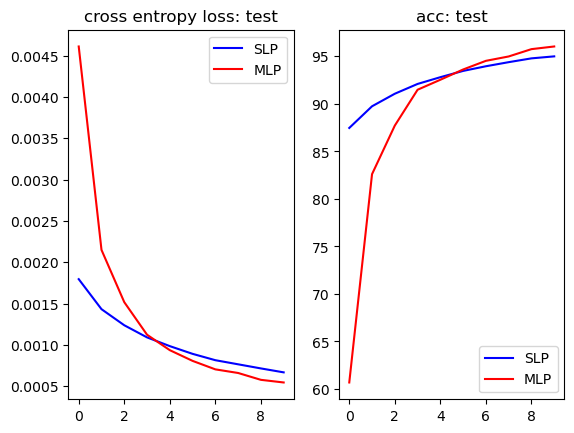

In [8]:

plt.figure
plt.subplot(1,2,1)
plt.plot(plt_loss_slp,'b')
plt.plot(plt_loss_mlp,'r')
plt.legend(['SLP','MLP'])
plt.title('cross entropy loss: test')

plt.subplot(1,2,2)
plt.plot(np.array(plt_acc_slp)*100,'b')
plt.plot(np.array(plt_acc_mlp)*100,'r')
plt.legend(['SLP','MLP'])
plt.title('acc: test')
plt.show()

## 利用CNN訓練MNIST分類

In [10]:
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
        
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(           
            ConvM(1, 32, 3, 1),
            ConvM(32, 64, 3, 1),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, 10)
    def forward(self, x):
        # x: batch* channel * w * h
        x = self.conv(x)
        # x: batch* channel * w * h
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        # x: batch* channel 
        ft = x
        output = self.fc(x)
        return output

# initialize the ConvNet
model_cnn = ConvNet()
print(model_cnn)

ConvNet(
  (conv): Sequential(
    (0): ConvM(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvM(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): ConvM(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvM(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): ConvM(
      (0): Conv2d(64, 3

In [12]:
import PIL.Image as Image
# transform = transforms.ToTensor()
transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
            transforms.ToTensor()
            ])

dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform= transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=256)

model_cnn = ConvNet().to(device)

loss = torch.nn.CrossEntropyLoss().to(device)

optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9)

plt_loss_cnn,plt_acc_cnn=[],[]
for epoch in range(10):
    # train
    model_cnn.train()
    
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP
        output_cnn = model_cnn(data) # batch * 10
        loss_cnn = loss(output_cnn, target) # batch * n_class, target: batch    
        model_cnn.zero_grad()
        loss_cnn.backward()
        optimizer_cnn.step()
      
        if batch_idx % 50 ==0 :
            print('CNN Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
                epoch, 
                100. * batch_idx / len(dataloader_train), 
                loss_cnn.item())
                 )
                   
    # Test
    model_cnn.eval()
    test_loss_cnn,  correct_cnn= 0, 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
             # CNN
            output_cnn = model_cnn(data)
            test_loss_cnn += loss(output_cnn, target)
            pred_cnn = output_cnn.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_cnn += pred_cnn.eq(target.view_as(pred_cnn)).sum().item()
            
    test_loss_cnn /= len(dataloader_test.dataset)
    print('CNN Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_cnn, correct_cnn, len(dataloader_test.dataset),
        100. * correct_cnn / len(dataloader_test.dataset)))
   
    plt_loss_cnn.append(test_loss_cnn.cpu().item())    
    plt_acc_cnn.append(correct_cnn / len(dataloader_test.dataset)) 

C:\Users\user\AppData\Local\Temp\ipykernel_12372\180498489.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),


CNN Train Epoch:0 [0.0%]	Loss: 2.319432
CNN Train Epoch:0 [21.3%]	Loss: 2.076305
CNN Train Epoch:0 [42.6%]	Loss: 1.734713
CNN Train Epoch:0 [63.8%]	Loss: 1.462484
CNN Train Epoch:0 [85.1%]	Loss: 1.264895
CNN Test set: Average loss: 0.0044, Accuracy: 7216/10000 (72%)
CNN Train Epoch:1 [0.0%]	Loss: 1.005623
CNN Train Epoch:1 [21.3%]	Loss: 0.885022
CNN Train Epoch:1 [42.6%]	Loss: 0.606480
CNN Train Epoch:1 [63.8%]	Loss: 0.512440
CNN Train Epoch:1 [85.1%]	Loss: 0.431788
CNN Test set: Average loss: 0.0016, Accuracy: 9288/10000 (93%)
CNN Train Epoch:2 [0.0%]	Loss: 0.358705
CNN Train Epoch:2 [21.3%]	Loss: 0.364050
CNN Train Epoch:2 [42.6%]	Loss: 0.287593
CNN Train Epoch:2 [63.8%]	Loss: 0.253427
CNN Train Epoch:2 [85.1%]	Loss: 0.217448
CNN Test set: Average loss: 0.0010, Accuracy: 9514/10000 (95%)
CNN Train Epoch:3 [0.0%]	Loss: 0.231443
CNN Train Epoch:3 [21.3%]	Loss: 0.208067
CNN Train Epoch:3 [42.6%]	Loss: 0.164166
CNN Train Epoch:3 [63.8%]	Loss: 0.193064
CNN Train Epoch:3 [85.1%]	Loss: 0.14

AttributeError: 'ConvNet' object has no attribute 'flush'

In [13]:
torch.save( model_cnn, 'model_CNN_MNIST.pth')
torch.save( model_mlp, 'model_MLP_MNIST.pth')

### 討論model.eval()和onnxruntime執行結果

In [16]:

dummy_input = torch.randn(1, 1, 28,28)
model_cnn = model_cnn.to(torch.device("cpu"))
torch.onnx.export(model_cnn, dummy_input, "cnn_trained.onnx")

dummy_input = torch.randn(1, 784)
model_mlp = model_mlp.to(torch.device("cpu"))
torch.onnx.export(model_mlp, dummy_input, "mlp_trained.onnx")

model_mlp.train()
with torch.no_grad():
    output_ft = model_mlp(dummy_input)
print('output:{}'.format(output_ft))


model_mlp.eval()
with torch.no_grad():
    output_ft = model_mlp(dummy_input)
print('output:{}'.format(output_ft))

import onnxruntime as ort
onnxmodel_path="mlp_trained.onnx"
session = ort.InferenceSession(onnxmodel_path, None)
input_name = session.get_inputs()[0].name
np_input = dummy_input.numpy()
outputs = session.run([], {input_name: np_input})[0] 
print("Output:{}".format(outputs))

output:tensor([[-3.4902,  2.4060, -2.0784,  5.9009, -2.7701,  3.0751, -5.6350,  3.2408,
         -0.9061,  3.3135]])
output:tensor([[-6.4064,  5.4606,  2.0386,  7.3556, -4.4814, -0.4473, -5.9163,  4.2780,
          0.4277,  2.2799]])
Output:[[-6.406414    5.460642    2.0386047   7.355641   -4.481355   -0.44734156
  -5.9162817   4.278042    0.42770755  2.279922  ]]


C:\Users\user\AppData\Local\Temp\ipykernel_16168\1823336179.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((28,28),Image.BICUBIC )


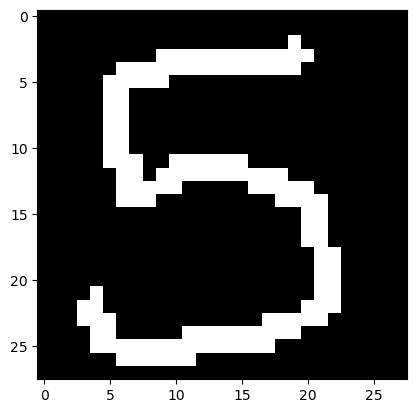

(1, 1, 28, 28)


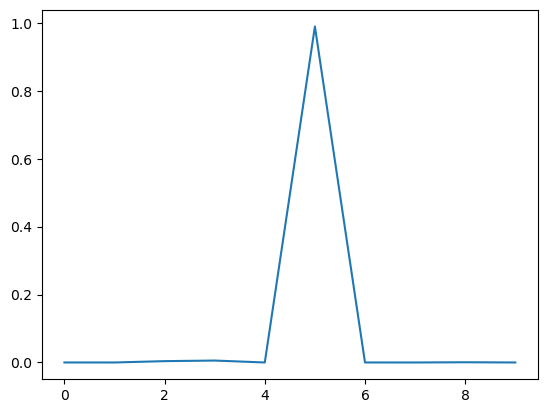

Output probability:[[7.1805065e-05 4.0737689e-09 3.9268159e-03 5.6686397e-03 8.7735975e-07
  9.8967350e-01 1.8648903e-05 5.3771930e-07 6.3541898e-04 3.7701329e-06]]
Output:5


In [43]:
import PIL.Image as Image
import onnxruntime as ort
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
mytransform = transforms.Compose([
            transforms.ToTensor(),
            ])
image_name='5-1.png'
image = Image.open(image_name, mode='r')
image = image.convert('1')
image = image.resize((28,28),Image.BICUBIC )
plt.imshow(image)
plt.show()

image_tensor = mytransform(image)
image_tensor = image_tensor.unsqueeze(0)
image_np = image_tensor.numpy()

print(image_np.shape)
onnxmodel_path="cnn_trained.onnx"
session = ort.InferenceSession(onnxmodel_path, None)
input_name = session.get_inputs()[0].name
outputs = session.run([], {input_name: image_np})[0] 

outputs = np.exp(outputs)
outputs /=np.sum(outputs)
plt.plot(outputs[0])
plt.show()
print("Output probability:{}".format(outputs))
print("Output:{}".format(np.argmax(outputs)))